In [1]:
import pandas as pd
import glob
import os
import librosa
import numpy as np
import scripts
import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

## Annotations

In [2]:
elan_annotation_paths = scripts.find_annotation_paths('.txt')
praat_annotation_paths = scripts.find_annotation_paths('.TextGrid')

In [3]:
elan_annotation_paths

['../annotations/surf.txt']

In [4]:
praat_annotation_paths

['../annotations/cursach2.TextGrid',
 '../annotations/gomes.TextGrid',
 '../annotations/lavina_class.TextGrid',
 '../annotations/arhis1.TextGrid',
 '../annotations/olya1.TextGrid',
 '../annotations/dashka.TextGrid',
 '../annotations/cursach1.TextGrid',
 '../annotations/artem_vps.TextGrid',
 '../annotations/ksenia.TextGrid',
 '../annotations/dima_arxiv.TextGrid',
 '../annotations/surf_test.TextGrid',
 '../annotations/dtp.TextGrid',
 '../annotations/vika2.TextGrid',
 '../annotations/sasha_code.TextGrid',
 '../annotations/vika1.TextGrid']

In [5]:
elan_annotations = scripts.get_elan_annotations(elan_annotation_paths)

In [6]:
elan_annotations[-1].head()

,start,finish,length,label
0,0.018,144.237,144.219,c
1,146.801,147.044,0.243,a
2,150.407,150.600,0.193,b
3,152.654,152.968,0.314,a
4,154.260,154.705,0.445,a


In [7]:
praat_annotations = scripts.get_praat_annotations(praat_annotation_paths)

In [8]:
praat_annotations[-1].head()

,finish,label,length,start
0,31.083253,,31.083253,0.000000
1,31.338213,b,0.254960,31.083253
2,46.990348,,15.652135,31.338213
3,47.465814,a,0.475467,46.990348
4,58.687152,,11.221337,47.465814


In [9]:
praat_annotations[1].head()

,finish,label,length,start
0,2.833521,,2.833521,0.000000
1,3.171171,a,0.337650,2.833521
2,22.459754,,19.288583,3.171171
3,22.594125,b,0.134371,22.459754
4,35.086819,,12.492694,22.594125


In [10]:
annotations = elan_annotations.copy()
annotations.extend(praat_annotations)

In [11]:
annotations_paths = elan_annotation_paths.copy()
annotations_paths.extend(praat_annotation_paths)

## Audio

In [12]:
annotations_paths

['../annotations/surf.txt',
 '../annotations/cursach2.TextGrid',
 '../annotations/gomes.TextGrid',
 '../annotations/lavina_class.TextGrid',
 '../annotations/arhis1.TextGrid',
 '../annotations/olya1.TextGrid',
 '../annotations/dashka.TextGrid',
 '../annotations/cursach1.TextGrid',
 '../annotations/artem_vps.TextGrid',
 '../annotations/ksenia.TextGrid',
 '../annotations/dima_arxiv.TextGrid',
 '../annotations/surf_test.TextGrid',
 '../annotations/dtp.TextGrid',
 '../annotations/vika2.TextGrid',
 '../annotations/sasha_code.TextGrid',
 '../annotations/vika1.TextGrid']

In [13]:
audio_paths = scripts.find_audio_from_annotations_paths(annotations_paths)
audio_paths

['../audio/surf.m4a',
 '../audio/cursach2.3gpp',
 '../audio/gomes.m4a',
 '../audio/lavina_class.m4a',
 '../audio/arhis1.m4a',
 '../audio/olya1.m4a',
 '../audio/dashka.m4a',
 '../audio/cursach1.3gpp',
 '../audio/artem_vps.m4a',
 '../audio/ksenia.m4a',
 '../audio/dima_arxiv.m4a',
 '../audio/surf_test.m4a',
 '../audio/dtp.m4a',
 '../audio/vika2.3gpp',
 '../audio/sasha_code.m4a',
 '../audio/vika1.m4a']

In [14]:
audios, sr = scripts.get_audios(audio_paths[-1:])
# audios, sr = scripts.get_audios(audio_paths)

## Demo examples of classes

In [19]:
data_a = scripts.get_label_data(annotations[-1], audios[-1], 'a', sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_a_tmp.wav', merged_data_a, sr)

In [20]:
data_a = scripts.get_label_data(annotations[-1], audios[-1], 'b', sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_b_tmp.wav', merged_data_a, sr)

In [21]:
data_a = scripts.get_unlabel_data(annotations[-1], audios[-1], ['a', 'b'], sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_c_tmp.wav', merged_data_a, sr)

## Creating dataset

In [14]:
interval_time = 0.3
interval_len = librosa.time_to_samples(interval_time)[0]

step_time = 0.05
step_len = librosa.time_to_samples(step_time)[0]

In [15]:
interval_len, step_len

(6615, 1102)

In [32]:
def get_label_data(annotation, audio, labels, sr=22050):
    data = []
    targets = []
    addings = []
    
    label_map = {'a': 0, 'b': 1, 'c': 2}
    for label in labels:
        l = label_map[label]
        start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
        finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
        for s, f in zip(start_samples_indxs, finish_samples_indxs):
            n = f - s
            i = 0
            while n >= interval_len:
                crop = np.array(audio[s + i * step_len:s + i * step_len + interval_len])
                data.append(crop)
                n -= step_len
                i += 1
                addings.append(0)
                targets.append(l)
            if n < interval_len:
                data.append(np.pad(audio[s + i * step_len:f], (0, interval_len - n),
                                   'mean'))
                addings.append(interval_len - n)
                targets.append(l)
    return data, targets, addings

In [33]:
d, t, a = get_label_data(annotations[-1], audios[-1], ['a', 'b'])

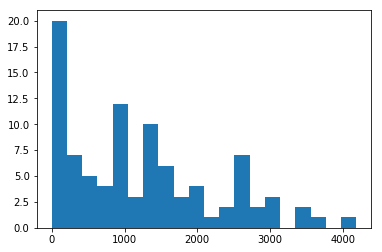

In [34]:
plt.hist(a, bins=20);

In [35]:
pd.Series.value_counts(t)

0    85
1     8
dtype: int64

In [36]:
set([len(dd) for dd in d])

{6615}

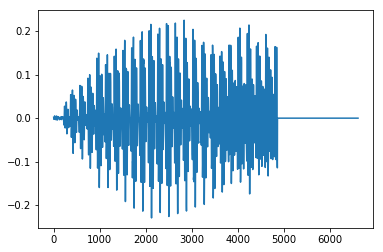

In [39]:
plt.plot(d[-10])

In [40]:
from IPython.display import Audio

In [41]:
wid = Audio(d[-2], rate=22050)

display(wid)

In [42]:
def get_unlabel_data(annotation, audio, labels, additions, sr=22050):
    data = []

    start_samples_indxs = librosa.time_to_samples(\
                          annotation[~annotation.label.isin(labels)].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(\
                           annotation[~annotation.label.isin(labels)].finish.values, sr)
    for s, f in zip(start_samples_indxs, finish_samples_indxs):
        n = f - s
        i = 0
        while n >= interval_len:
            crop = np.array(audio[s + i * interval_len:s + (i + 1) * interval_len])
            # because random value 0 is bad for slicing, set minimum value 1
#             sl = max(int(np.random.exponential(exp_dist_scale)), 1)
            # limit maximum random value by 70% of interval_len
#             sl = min(sl, int(interval_len * max_crop_percent))

            # another version - better
            sl = np.random.choice(additions)
            if sl != 0:
                crop = crop[:-sl]
                crop = np.pad(crop, (0, sl), 'mean')
            data.append(crop)
            n -= interval_len
            i += 1
    targets = [2] * len(data)
    return data, targets

In [43]:
len(annotations), len(audios)

(10, 10)

## Dataset

In [44]:
X, y = [], []
X_c = []
additions = []

labels_map = {
    'a': 0,
    'b': 1,
    'c': 2
}

for ann, aud in zip(annotations, audios):
    data, targets, adds = get_label_data(ann, aud, ['a', 'b'])
    X.extend(data)
    y.extend(targets)
    additions.extend(adds)
    
for ann, aud in zip(annotations, audios):
    data, targets = get_unlabel_data(ann, aud, ['a', 'b'], additions)
    X_c.extend(data)

c_indxs = np.random.choice(range(len(X_c)), len(X_c) // 2, replace=False)
X.extend(np.array(X_c)[c_indxs].tolist())
y.extend([2] * (len(X_c) // 2))

In [45]:
len(X), len(y)

(12202, 12202)

In [46]:
pd.Series.value_counts(y)

2    10042
0     1835
1      325
dtype: int64

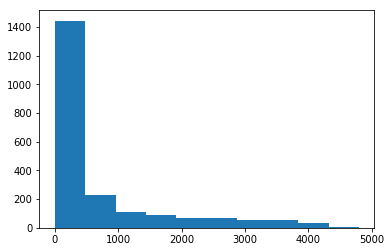

In [47]:
plt.hist(additions);

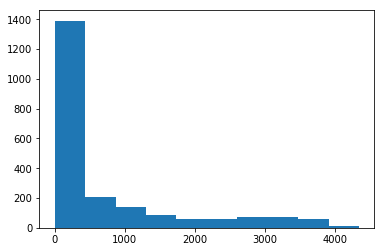

In [48]:
plt.hist(np.random.choice(additions, len(additions)));

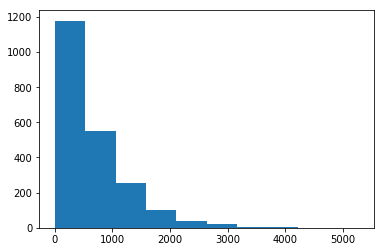

In [49]:
plt.hist(np.random.exponential(np.mean(additions), len(additions)));

### Shuffle

In [50]:
import random

In [51]:
temp = list(zip(X, y))
random.shuffle(temp)
X, y = zip(*temp)

## Lol save

In [61]:
xs = [x_ for x_, y_ in zip(X, y) if y_ == 1]

In [62]:
xs = np.concatenate(xs)

In [67]:
xs = np.concatenate(X[:100])

In [68]:
Audio(xs, rate=sr)

In [60]:
librosa.output.write_wav('../demo/eee.wav', xs, sr)

### Pickle

In [64]:
import pickle
import gzip

In [65]:
with gzip.open('../cache/dataset.pkl.gz', 'wb') as f:
    pickle.dump([X, y], f)

In [66]:
sr

22050